In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from hsi_cnn_reader import hsi_cnn_reader
from keras.models import load_model
import h5py
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
from progressbar import ProgressBar

# Load Model

In [20]:
# model to predict
model = load_model('model_1_2.h5')

In [26]:
# what to predict? 
crop_1_data_path = '/home/ec2-user/Capstone_Project/code/crop_1'
crop_mask_1_path = '/home/ec2-user/Capstone_Project/code/crop_mask_1'

In [104]:
crop_2_data_path = '/home/ec2-user/Capstone_Project/code/crop_2'
crop_mask_2_path = '/home/ec2-user/Capstone_Project/code/crop_mask_2'

In [33]:
# Check Model Architecture
for layer in model.layers:
    print(layer.trainable, layer.name)

True conv2d_1
True batch_normalization_1
True activation_1
True max_pooling2d_1
True conv2d_2
True batch_normalization_2
True activation_2
True conv2d_3
True batch_normalization_3
True activation_3
True max_pooling2d_2
True flatten_1
True dense_1
True batch_normalization_4
True activation_4
True dropout_1
True dense_2
True activation_5


# Prediction

In [60]:
def cnn_classify_batch(data_path, masks_path, crop_size, num_classes, model, npixels):

    # create reader object 
    reader = hsi_cnn_reader(data_path,
                            masks_path,
                            crop_size=(crop_size, crop_size),
                            npixels=npixels)
    # npixels = number of pixels to predict in each batch
    # num_samples = total number of pixels to predict (rows*columns - background)
    # rows = number of pixels'row in given picture (crop)
    # columns = number of pixels'columns in given picture (crop)
    # num_bands = number of bands (here is 16)
    # prob_image = probability of each class for each pixel (rows,columns,num_classe = 6)
    num_samples, num_bands, rows, cols = reader.data_dims()
    prob_image = np.zeros((rows, cols, num_classes), dtype=np.float32)
    
    pbar = ProgressBar(maxval=num_samples).start()
    k = 0
    
    # input shape (npixels,crop_size,crop_size,num_bands)
    # labels shape (npixels)
    # idx: indices of non background pixels to predict (npixels,2)
    for (input_, labels, idx) in reader:
        if len(input_) > 0:
            prediction = model.predict(input_)
            prob_image[idx[:, 0], idx[:, 1], :] = np.asarray(prediction)
            k += len(input_)
            pbar.update(k)
    return prob_image

In [61]:
prob_image = cnn_classify_batch(data_path = crop_1_data_path,
                               masks_path = crop_mask_1_path,
                               crop_size = 33,
                               num_classes = 6,
                               model = model, 
                               npixels = 100)

In [64]:
prob_image.shape

(1344, 1376, 6)

In [89]:
def prob_image_plot(prob_image, axs, num_classes = 6, classes_name = None, color='gist_gray'):    
    for i in range(num_classes):
        axs = axs.ravel()
        axs[i].imshow(prob_image[:,:,i],cmap=color)
        axs[i].xaxis.set_major_locator(plt.NullLocator())  # remove xticks and yticks
        axs[i].yaxis.set_major_locator(plt.NullLocator())
        if classes_name:
            axs[i].set_title('{}'.format(classes_name[i]))
        else:
            axs[i].set_title('Class {}'.format(i+1))

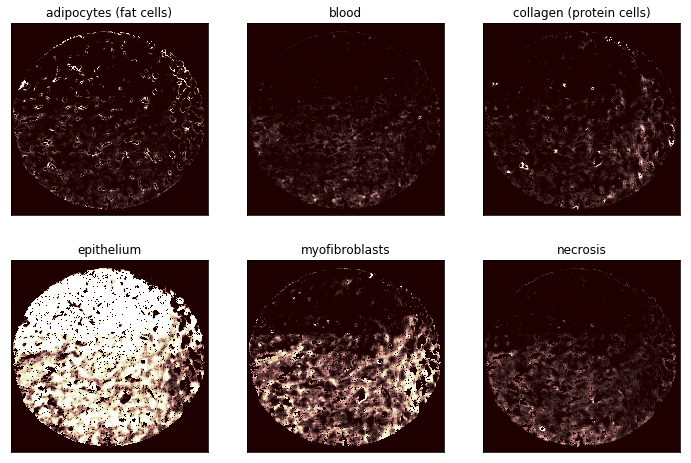

In [96]:
# https://matplotlib.org/users/colormaps.html
# colors = ['bone','pink','summer','autumn','winter','spring','gist_gray']
classes_name = ['adipocytes (fat cells)','blood','collagen (protein cells)',\
                'epithelium','myofibroblasts','necrosis']
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
prob_image_plot(prob_image, axs, num_classes = 6, classes_name = classes_name , color='pink')

In [79]:
import colorsys

In [80]:
def prob2class(prob_image):
    # change prob_image dimensionless from (rows, columns, num_classe = 6) to (num_classe = 6, rows, columns)
    prob_image = np.rollaxis(prob_image, 2, 0)
    class_image = np.zeros(prob_image.shape, dtype=np.bool)
    # get nonzero indices
    nz_idx = np.transpose(np.nonzero(np.sum(prob_image, axis=0)))    
    # set pixel corresponding to max probability to 1
    for idx in nz_idx:
        idx_max_prob = np.argmax(prob_image[:, idx[0], idx[1]])
        class_image[idx_max_prob, idx[0], idx[1]] = 1
    return class_image

In [184]:
# generate N qualitative colors and return the value for color c
def qualcolor(c, N):
    dN = np.ceil(np.sqrt(N)).astype(np.int32)
    h = c/N
    
    sp = c/N * 2 * np.pi * dN + np.pi/2
    s = np.sin(sp) * 0.25 + 0.75
    
    vp = c/N * 2 * np.pi * dN
    v = np.sin(vp) * 0.25 + 0.75
    
    rgb = np.array(colorsys.hsv_to_rgb(h, s, v))
    return rgb * 255

In [185]:
def class2color(C):   
    #determine the number of classes
    nc = C.shape[0]    
    s = C.shape[1:]
    s = np.append(s, 3)
    #generate an RGB image
    RGB = np.zeros(s, dtype=np.ubyte)
    
    # user-defined colors for each class 
    # https://www.webucator.com/blog/2015/03/python-color-constants-module/
    # class 1 = 'adipocytes (fat cells)'   >>>> yellow            (255,255,0)
    # class 2 = 'blood'                    >>>> red               (255,0,0)
    # class 3 = 'collagen (protein cells)' >>>> green             (48,128,20)   
    # class 4 = 'epithelium'               >>>> paleturquoise1    (187,255,255)
    # class 5 = 'myofibroblasts'           >>>> blue              (0,0,255) 
    # class 6 = 'necrosis'                 >>>> purple            (145,44,238) 
    color = [(255,255,0),(255,0,0),(48,128,20),(187,255,255),(0,0,255),(145,44,238)]
    #for each class
    for c in range(0, nc):
        # # use qualcolor function
        # color = qualcolor(c, nc)
        # RGB[C[c, ...], :] = color
        
        ## user predefined colors 
        RGB[C[c,:,:], :] = color[c]
        
    return RGB

In [186]:
class_image = prob2class(prob_image)
RGB = class2color(class_image)

In [190]:
# class_image.shape, RGB.shape

((6, 1344, 1376), (1344, 1376, 3))

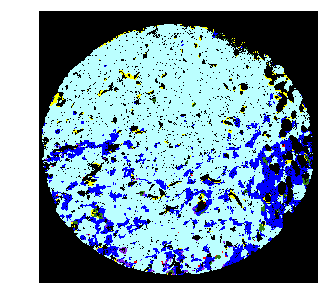

In [205]:
plt.figure(figsize=(5,5))
plt.imshow(RGB)
plt.axis('off')
plt.show()

In [105]:
prob_image_2 = cnn_classify_batch(data_path = crop_2_data_path,
                                  masks_path = crop_mask_2_path,
                                  crop_size = 33,
                                  num_classes = 6,
                                  model = model, 
                                  npixels = 100)

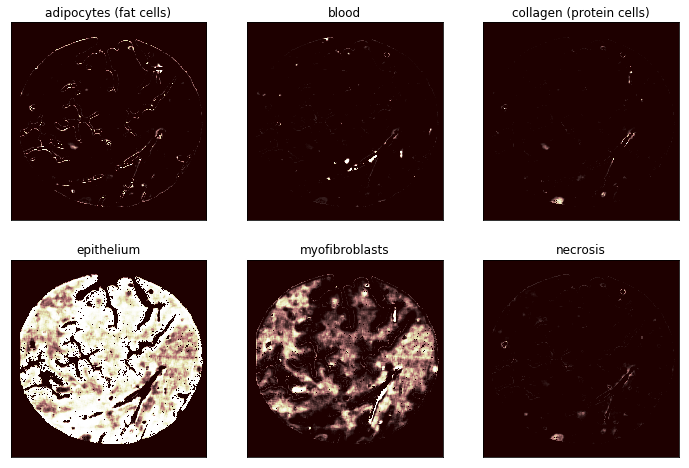

In [193]:
classes_name = ['adipocytes (fat cells)','blood','collagen (protein cells)',\
                'epithelium','myofibroblasts','necrosis']
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
prob_image_plot(prob_image_2, axs, num_classes = 6, classes_name = classes_name , color='pink')

In [194]:
class_image_2 = prob2class(prob_image_2)
RGB_2 = class2color(class_image_2)

In [218]:
# from matplotlib.colors import ListedColormap

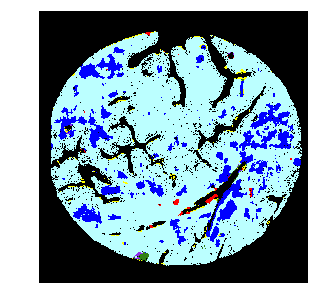

In [219]:
plt.figure(figsize=(5,5))
plt.imshow(RGB_2)
plt.axis('off')
plt.show()

In [206]:
# import webcolors